In [4]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

import numpy as np
from keras.datasets import cifar10
from random import randrange
import time
import pickle

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 12) # set default size of plots

In [ ]:
from imgaug import augmenters as iaa

seq = iaa.Sequential([
    iaa.OneOf([
        iaa.Fliplr(1), # horizontally flip 50% of the images
        iaa.Flipud(1),
        iaa.GaussianBlur(sigma=(0, 1.0)), # blur images with a sigma of 0 to 3.0
          iaa.Affine(
              scale={"x": (0.7, 1), "y": (0.7, 1)},
              shear=(-16, 16),
              rotate=(-45, 45)
          ),  
        iaa.Dropout((0.01, 0.15),per_channel=False),
        iaa.Pad(percent=((0.05, 0.3),(0.05, 0.3),(0.05, 0.3),(0.05, 0.3)))
    ]),
    iaa.Sometimes(0.5,[
        iaa.Sharpen(alpha=(0, 1.0), lightness=(0.1, 1.5)),
        iaa.Grayscale(alpha=(0.0, 1.0)),
        iaa.Invert(1, per_channel=True)
    ])
], True)

batch_size = 64
batch_cnt = x_train.shape[0]//batch_size
epoches = 5

all_aug_x = np.resize(np.array([]),[0,32,32,3])
all_aug_y = np.resize(np.array([]),[0,])

for i_epoch in range(epoches):
    x_idx = np.arange(x_train.shape[0])
    np.random.shuffle(x_idx)
    for batch_idx in range(500):
        # 'images' should be either a 4D numpy array of shape (N, height, width, channels)
        # or a list of 3D numpy arrays, each having shape (height, width, channels).
        # Grayscale images must have shape (height, width, 1) each.
        # All images must have numpy's dtype uint8. Values are expected to be in
        # range 0-255.

        images = x_train[x_idx[batch_size*batch_idx:batch_size*(1+batch_idx)]]  # you have to implement this function
        images_aug = seq.augment_images(images) 

        y_aug = y_train[x_idx[batch_size*batch_idx:batch_size*(1+batch_idx)]]
    
        all_aug_x = np.concatenate([all_aug_x,images_aug])
        all_aug_y = np.concatenate([all_aug_y,y_aug])

        

pickle.dump(all_aug_x,open('aug_image/x_images.p','wb'))
pickle.dump(all_aug_y,open('aug_image/y_images.p','wb'))


In [5]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 12)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

n_cols = 5
tot_plots = 10
n_rows = tot_plots//n_cols+1

idx_to_plot = np.arange(images_aug.shape[0])
np.random.shuffle(idx_to_plot)

for i,i_idx in enumerate(idx_to_plot[:10]):
    #plt.subplot(1+i // 10, 1+i%10, i)
    plt.subplot(n_rows, n_cols, 1+i)
    
    plt.imshow(images_aug[i_idx].astype('uint8'))
    plt.axis('off')
    
    cls = classes[y_aug[i_idx]]
    plt.title(cls)

plt.show()

NameError: name 'images_aug' is not defined

Для обучения мы будем использовать датасет CIFAR-10, состоящий из 60000 цветных изображений размера 32x32, разбитых на 10 классов, по 6000 изображений на класс. Обучающая выборка состоит из 50000 изображений, а тестовая -- из 10000. 

In [5]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

y_train = np.squeeze(y_train)
y_test = np.squeeze(y_test)


In [6]:
print (x_train.shape)
print (y_train.shape)

all_aug_x = pickle.load(open('aug_image/x_images.p','rb'))
all_aug_y = pickle.load(open('aug_image/y_images.p','rb'))


x_train = np.concatenate([x_train,all_aug_x])
y_train = np.concatenate([y_train,all_aug_y])

print (x_train.shape)
print (y_train.shape)

(50000, 32, 32, 3)
(50000,)
(210000, 32, 32, 3)
(210000,)


Визуализируем классы

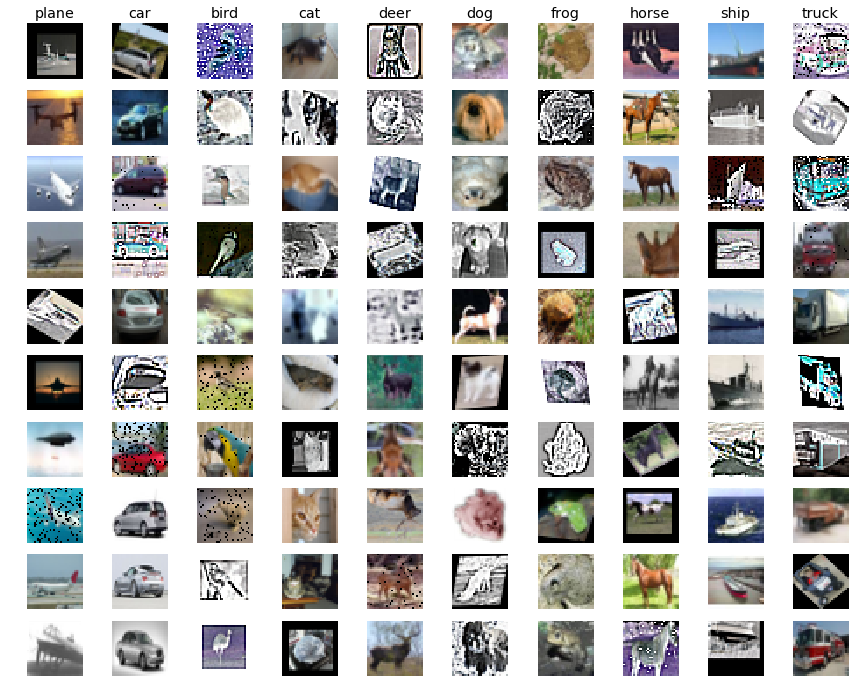

In [7]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 10
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(x_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

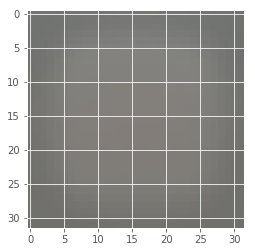

In [8]:
# Preprocessing: вычитаем среднее
# 1: Находим среднее изображение
mean_image = np.mean(x_train, axis=0)
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # визуализируем полученное среднее
plt.show()

In [9]:
# 2: вычитаем среднее из изображений обучающей и тестовых выборок
x_train = x_train - mean_image
x_test = x_test - mean_image

In [10]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=1000)

Попробуем решить задачу при помощи простой нейронной сети. Сначала объявим функцию, описывающую граф модели.

In [18]:
def build_simple_model():
    # placeholder'ы это точки входа, можно восприпимать их, как аргументы функции, описываемой графом
    x = tf.placeholder(tf.float32, [None, 32, 32, 3])
    y = tf.placeholder(tf.int64, [None])
    is_training = tf.placeholder(tf.bool)

    #variable scope задаёт префикс для всех элементов внутри него
    #Это позволяет огранизовавывать структуру графа и вашего кода
    with tf.variable_scope("convolution_layer_1"):
        #создаём веса (W -- ядра свёрток, b -- сдвиг)
        Wconv1 = tf.get_variable("Wconv1", shape=[7, 7, 3, 32])
        bconv1 = tf.get_variable("bconv1", shape=[32])
        
        a1 = tf.nn.conv2d(x, Wconv1, strides=[1,2,2,1], padding='VALID') + bconv1
        h1 = tf.nn.relu(a1)


    #добавляем полносвязный слой
    with tf.variable_scope("dense_layer_1"):
        W1 = tf.get_variable("W1", shape=[5408, 4096])
        b1 = tf.get_variable("b1", shape=[4096])
        
        h1 = tf.reshape(h1,[-1,5408])
        y_out = tf.matmul(h1,W1) + b1

#     y_out = tf.layers.batch_normalization(y_out, training=is_training)   

    #добавляем полносвязный слой
    with tf.variable_scope("dense_layer_2"):
        W1 = tf.get_variable("W1", shape=[4096, 10])
        b1 = tf.get_variable("b1", shape=[10])
        
        y_out = tf.matmul(y_out,W1) + b1
        
        
    # y_out -- это вектор оценок, которые генерирует модель. Теперь определим функцию потерь
    total_loss = tf.losses.hinge_loss(tf.one_hot(y,10),logits=y_out)
    mean_loss = tf.reduce_mean(total_loss)
    
    correct_prediction = tf.equal(tf.argmax(y_out,1), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    tf.summary.scalar('mean_loss', mean_loss)
    tf.summary.scalar('accuracy', accuracy)
            
    #Возвращаем те узлы графа, которые нам понадобятся в дальнейшем.
    #(x,y) это входы графа, а (y_out, mean_loss) выходы, которые представляют для нас интерес
    return (x,y,is_training), (y_out, mean_loss, accuracy)

Написанная выше функция не осуществляет никаких вычислений, единственное её предназначение -- описание графа.

In [19]:
#Перед вызовом функции очистим память от графов других моделей (актуально если вы вызываете эту ячейку повторно)
tf.reset_default_graph()
(x,y,is_training), (y_out, mean_loss, accuracy) = build_simple_model()

merged = tf.summary.merge_all()

#Теперь зададим алгоритм оптимизации
optimizer = tf.train.AdamOptimizer(5e-5) 
#train_step -- специальный служебный узел в графе, отвечающий за обратный проход
train_step = optimizer.minimize(mean_loss) 

Пожалуйста, ознакомьтесь с другими возможностями, которые предоставляет tf для описания модели. 

* Layers, Activations, Loss functions : https://www.tensorflow.org/api_guides/python/nn
* Optimizers: https://www.tensorflow.org/api_guides/python/train#Optimizers
* BatchNorm: https://www.tensorflow.org/api_docs/python/tf/layers/BatchNormalization

Теперь мы можем двигаться дальше и протестировать получившуюся модель. Для этого реализуем тренировочный цикл


In [20]:
def training_loop(session, model_inputs, model_outputs, train_step, 
                  epochs=10, batch_size=64):
    
    train_writer = tf.summary.FileWriter('tensorboard/train',session.graph)
    val_writer = tf.summary.FileWriter('tensorboard/val')

    #создаём индекс по всем объектам
    index = np.arange(len(x_train))
    
    #перемешиваем его
    np.random.shuffle(index)
    
    #разбиваем на батчи
    num_batches = int(len(index) / batch_size)
    batch_indexes = np.array_split(index, num_batches)
    
    #аналогично для теста
    index_test = np.arange(len(x_test))
    np.random.shuffle(index_test)
    num_batches_test = int(len(index_test) / batch_size)
    batch_indexes_test = np.array_split(index_test, num_batches_test)
    
    #аналогично для validation
    index_val = np.arange(len(x_val))
    np.random.shuffle(index_val)
    num_batches_val = int(len(index_val) / batch_size)
    batch_indexes_val = np.array_split(index_val, num_batches_val)
    
    x,y = model_inputs
    y_out, mean_loss, accuracy = model_outputs
    
    def train(x_values, y_values, batch_indexes, epoch):
        train_loses = []
        for i, batch_index in enumerate(batch_indexes):

            #Создаём словарь, осуществляющий сопоставление входов графа (plaseholders) и значений
            feed_dict = {x: x_values[batch_index],
                         y: y_values[batch_index],
                        is_training:True}

            #Здесь происходит непоследственный вызов модели
            #Обратите внимание, что мы передаём 
                      
            summary, scores, loss, acc, _ = session.run([merged,y_out, mean_loss, accuracy, train_step],feed_dict=feed_dict)

            train_loses.append(loss)
            print(f'iteration {i}, train loss: {loss:.3}, accuracy: {acc:.3}', end='\r')
            
            train_writer.add_summary(summary, epoch * num_batches+i)

        return train_loses
        
    def evaluate(x_values, y_values, batch_indexes, epoch):
        test_loses = []
        test_accuracy = []

        i_to_save = np.random.randint(0,high=len(batch_indexes),size=1)[0]
        for batch_index in batch_indexes:

            #Создаём словарь, осуществляющий сопоставление входов графа (plaseholders) и значений
            feed_dict = {x: x_values[batch_index],
                         y: y_values[batch_index],
                        is_training:True}
            
            #Здесь происходит непоследственный вызов модели
            
            summary, loss, acc = session.run([merged,mean_loss, accuracy],feed_dict=feed_dict)
                 
            if i_to_save==0:
                val_writer.add_summary(summary, epoch * num_batches)
            
            i_to_save = i_to_save - 1
            
            test_loses.append(loss)
            test_accuracy.append(acc)

        return test_loses, test_accuracy
    
        
    # цикл по эпохам
    for e in range(epochs):
        print(f'Epoch {e}:')
        train_loses = train(x_train, y_train, batch_indexes, e)
        val_loses, val_accuracy = evaluate(x_val, y_val, batch_indexes_val, e)
        print(f'train loss: {np.mean(train_loses):.3}, val loss: {np.mean(val_loses):.3}, accuracy: {np.mean(val_accuracy):.3}')

            
    print('================================================')
    print('Test set results:')
    test_loses, test_accuracy = evaluate(x_test, y_test, batch_indexes_test,e)
    print(f'test loss: {np.mean(test_loses):.3}, accuracy: {np.mean(test_accuracy):.3}')

In [21]:
## Печатаем в tensorboard

# создаём сессию. Сессия -- это среда, в которой выполняются вычисления
with tf.Session() as sess:
        
    #мы можем явно указать устройство
    with tf.device("/gpu:0"): #"/cpu:0" or "/gpu:0" 
        #инициализируем веса, в этот момент происходит выделение памяти
        sess.run(tf.global_variables_initializer())
        
        #запускаем тренировку
        training_loop(sess, model_inputs=(x,y), 
                      model_outputs=(y_out, mean_loss, accuracy), 
                      train_step=train_step, epochs=20)

Epoch 0:


KeyboardInterrupt: 

Как видим, даже самая простая модель показывает очень неплохие результаты

**Задача 1:** Модифицируйте предыдущий код так, чтобы данные о тренировке (train\val loss) выводились в tensorboard. Изучите визуализацию графа модели.

**Задача 2 (основная)** Реализуйте сеть, подобную [VGG-16](https://arxiv.org/pdf/1409.1556.pdf) (или любую другую), для решения задачи. При реализации вам не разрешается пользоваться модулем **tf.layers** за исключением **tf.layers.batch_normalization** и **tf.layers.dropout**. Обратите внимание, что VGG-16 заточена под изображения большего разрешения.

Затем, после того, как сеть будет реализована постарайтесь получить масимально возможную точность, используя методы, описанные в лекциях (batch normalization, расписание learning rate, поменяйте функции активации, аугментация данных и т.д.). Результаты каждого слушателя затем будут занесены в таблицу и вывешены в репозитории курса.

Принимаются работы с точностью **не менее 84%**. 

Полезные ссылки:
  - [ResNet](https://arxiv.org/abs/1512.03385).
  - [DenseNet](https://arxiv.org/abs/1608.06993).
  - [This blog has an in-depth overview](https://chatbotslife.com/resnets-highwaynets-and-densenets-oh-my-9bb15918ee32)

Напишите ваш код под текстом задания

### My network

In [22]:
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D



In [30]:
## https://gist.github.com/baraldilorenzo/07d7802847aaad0a35d3
##

def my_vgg16():
    # placeholder'ы это точки входа, можно восприпимать их, как аргументы функции, описываемой графом
     
    x = tf.placeholder(tf.float32, [None, 32, 32, 3])
    y = tf.placeholder(tf.int64, [None])
    
    is_training = tf.placeholder(tf.bool)

    
    #variable scope задаёт префикс для всех элементов внутри него
    #Это позволяет огранизовавывать структуру графа и вашего кода
    with tf.variable_scope("conv_1"):
        #создаём веса (W -- ядра свёрток, b -- сдвиг)
        Wconv = tf.get_variable("Wconv1", shape=[3, 3, 3, 64])
        bconv = tf.get_variable("bconv1", shape=[64])
        
        a1 = tf.nn.conv2d(x, Wconv, strides=[1,1,1,1], padding='SAME') + bconv
        a2 = tf.layers.batch_normalization(a1, training=is_training)                            
        nn = tf.nn.relu(a2)
        
        
    with tf.variable_scope("conv_2"):
        #создаём веса (W -- ядра свёрток, b -- сдвиг)
        Wconv = tf.get_variable("Wconv2", shape=[3, 3, 64, 64])
        bconv = tf.get_variable("bconv2", shape=[64])
        
        a1 = tf.nn.conv2d(nn, Wconv, strides=[1,1,1,1], padding='SAME') + bconv
        a2 = tf.layers.batch_normalization(a1, training=is_training)                            
        nn = tf.nn.relu(a2)
    
    with tf.variable_scope("max_pool_1"):
        nn = tf.nn.max_pool(nn,ksize=[1,2,2,1],strides = [1,1,1,1],padding = 'SAME') ## (?, 32, 32, 64)
    
    
    with tf.variable_scope("conv_3"):
        #создаём веса (W -- ядра свёрток, b -- сдвиг)
        Wconv = tf.get_variable("Wconv3", shape=[3, 3, 64, 128])
        bconv = tf.get_variable("bconv3", shape=[128])
        
        a1 = tf.nn.conv2d(nn, Wconv, strides=[1,1,1,1], padding='SAME') + bconv
        a2 = tf.layers.batch_normalization(a1, training=is_training)                            
        nn = tf.nn.relu(a2)
        
        
    with tf.variable_scope("conv_4"):
        #создаём веса (W -- ядра свёрток, b -- сдвиг)
        Wconv = tf.get_variable("Wconv4", shape=[3, 3, 128, 128])
        bconv = tf.get_variable("bconv4", shape=[128])
        
        a1 = tf.nn.conv2d(nn, Wconv, strides=[1,1,1,1], padding='SAME') + bconv
        a2 = tf.layers.batch_normalization(a1, training=is_training)                            
        nn = tf.nn.relu(a2)
    
    with tf.variable_scope("max_pool_2"):
        nn = tf.nn.max_pool(nn,ksize=[1,2,2,1],strides = [1,1,1,1],padding = 'SAME') ## (?, 32, 32, 128)
        
        
    with tf.variable_scope("conv_5"):
        #создаём веса (W -- ядра свёрток, b -- сдвиг)
        Wconv = tf.get_variable("Wconv3", shape=[3, 3, 128, 256])
        bconv = tf.get_variable("bconv3", shape=[256])
        
        a1 = tf.nn.conv2d(nn, Wconv, strides=[1,1,1,1], padding='SAME') + bconv
        a2 = tf.layers.batch_normalization(a1, training=is_training)                            
        nn = tf.nn.relu(a2)
        
        
    with tf.variable_scope("conv_6"):
        #создаём веса (W -- ядра свёрток, b -- сдвиг)
        Wconv = tf.get_variable("Wconv4", shape=[3, 3, 256, 256])
        bconv = tf.get_variable("bconv4", shape=[256])
        
        a1 = tf.nn.conv2d(nn, Wconv, strides=[1,1,1,1], padding='SAME') + bconv
        a2 = tf.layers.batch_normalization(a1, training=is_training)                            
        nn = tf.nn.relu(a2)
    
    with tf.variable_scope("max_pool_3"):
        nn = tf.nn.max_pool(nn,ksize=[1,2,2,1],strides = [1,2,2,1],padding = 'VALID') ## (?, 16, 16, 256)
        
    with tf.variable_scope("conv_7"):
        #создаём веса (W -- ядра свёрток, b -- сдвиг)
        Wconv = tf.get_variable("Wconv3", shape=[3, 3, 256, 512])
        bconv = tf.get_variable("bconv3", shape=[512])
        
        a1 = tf.nn.conv2d(nn, Wconv, strides=[1,1,1,1], padding='SAME') + bconv
        a2 = tf.layers.batch_normalization(a1, training=is_training)                            
        nn = tf.nn.relu(a2)
                
    with tf.variable_scope("conv_8"):
        #создаём веса (W -- ядра свёрток, b -- сдвиг)
        Wconv = tf.get_variable("Wconv4", shape=[3, 3, 512, 512])
        bconv = tf.get_variable("bconv4", shape=[512])
        
        a1 = tf.nn.conv2d(nn, Wconv, strides=[1,1,1,1], padding='SAME') + bconv
        a2 = tf.layers.batch_normalization(a1, training=is_training)                            
        nn = tf.nn.relu(a2)
    
    with tf.variable_scope("max_pool_4"):
        nn = tf.nn.max_pool(nn,ksize=[1,2,2,1],strides = [1,2,2,1],padding = 'VALID') ## (?, 8, 8, 512)
    
    
    #добавляем полносвязный слой
    with tf.variable_scope("dense_layer_1"):
        size = 8*8*512
        W1 = tf.get_variable("W1", shape=[size, 4096])
        b1 = tf.get_variable("b1", shape=[4096])
        
        nn = tf.reshape(nn,[-1,size])
        nn = tf.matmul(nn,W1) + b1  
        
        nn = tf.layers.batch_normalization(nn, training=is_training)                    
    
        nn = tf.nn.relu(nn)
        nn = tf.nn.dropout(nn, keep_prob=0.5)
        
        
    with tf.variable_scope("dense_layer_2"):
        W1 = tf.get_variable("W1", shape=[4096, 4096])
        b1 = tf.get_variable("b1", shape=[4096])
        nn = tf.matmul(nn,W1) + b1
        nn = tf.layers.batch_normalization(nn, training=is_training)                                            
        nn = tf.nn.relu(nn)
        
        
    with tf.variable_scope("dense_layer_3"):
        W1 = tf.get_variable("W1", shape=[4096, 10])
        b1 = tf.get_variable("b1", shape=[10])
        
        y_out = tf.matmul(nn,W1) + b1

        
    # y_out -- это вектор оценок, которые генерирует модель. Теперь определим функцию потерь
    total_loss = tf.losses.hinge_loss(tf.one_hot(y,10),logits=y_out)
    mean_loss = tf.reduce_mean(total_loss)
    
    correct_prediction = tf.equal(tf.argmax(y_out,1), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    tf.summary.scalar('mean_loss', mean_loss)
    tf.summary.scalar('accuracy', accuracy)
            
    #Возвращаем те узлы графа, которые нам понадобятся в дальнейшем.
    #(x,y) это входы графа, а (y_out, mean_loss) выходы, которые представляют для нас интерес
    return (x,y,is_training), (y_out, mean_loss, accuracy)

In [31]:
#Перед вызовом функции очистим память от графов других моделей (актуально если вы вызываете эту ячейку повторно)
tf.reset_default_graph()
(x,y,is_training), (y_out, mean_loss, accuracy) = my_vgg16()

merged = tf.summary.merge_all()


#Теперь зададим алгоритм оптимизации
optimizer = tf.train.AdamOptimizer(5e-5) 
#train_step -- специальный служебный узел в графе, отвечающий за обратный проход
train_step = optimizer.minimize(mean_loss) 

In [32]:

# создаём сессию. Сессия -- это среда, в которой выполняются вычисления
with tf.Session() as sess:
        
    #мы можем явно указать устройство
    with tf.device("/gpu:0"): #"/cpu:0" or "/gpu:0" 
        #инициализируем веса, в этот момент происходит выделение памяти
        sess.run(tf.global_variables_initializer())
        
        #запускаем тренировку
        training_loop(sess, model_inputs=(x,y), 
                      model_outputs=(y_out, mean_loss, accuracy), 
                      train_step=train_step, epochs=60)

Epoch 0:
train loss: 0.215, val loss: 0.185, accuracy: 0.548
Epoch 1:
train loss: 0.159, val loss: 0.154, accuracy: 0.634
Epoch 2:
train loss: 0.127, val loss: 0.133, accuracy: 0.708
Epoch 3:
train loss: 0.101, val loss: 0.131, accuracy: 0.732
Epoch 4:
train loss: 0.0784, val loss: 0.123, accuracy: 0.769
Epoch 5:
train loss: 0.059, val loss: 0.124, accuracy: 0.768
Epoch 6:
train loss: 0.0443, val loss: 0.117, accuracy: 0.791
Epoch 7:
train loss: 0.0338, val loss: 0.12, accuracy: 0.7879
Epoch 8:
train loss: 0.0267, val loss: 0.135, accuracy: 0.789
Epoch 9:
train loss: 0.0221, val loss: 0.132, accuracy: 0.799
Epoch 10:
train loss: 0.0187, val loss: 0.132, accuracy: 0.844
Epoch 11:
train loss: 0.0161, val loss: 0.137, accuracy: 0.796
Epoch 12:
train loss: 0.0142, val loss: 0.134, accuracy: 0.813
Epoch 13:
train loss: 0.0127, val loss: 0.124, accuracy: 0.813
Epoch 14:
train loss: 0.0115, val loss: 0.13, accuracy: 0.8034
Epoch 15:
train loss: 0.0106, val loss: 0.131, accuracy: 0.806
Epoch 1